In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pip -q install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [102]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import optim

from astaragent import MyAgent
from models import DRQNNetwork
from simulate import run_episode_for_imitation_learning

policy_net_path = "./policy_net"
mixing_net_path = "./mixing_net"

In [103]:
def run_episode(config, heuristic_agent, device) -> tuple[torch.Tensor, torch.Tensor]:
    state_list, action_list = run_episode_for_imitation_learning(config, heuristic_agent)
    state_array = np.stack(state_list)
    action_array = np.stack(action_list)

    states = torch.from_numpy(state_array).to(device).permute((1, 0, 2))
    actions = torch.from_numpy(action_array).to(device)
    return states, actions

In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def sample_config() -> None:
    rng = np.random.default_rng()
    return {
        "grid_size": rng.integers(10, 31),
        "walls_proportion": rng.uniform(0.1, 0.6),
        "num_dynamic_obstacles": rng.integers(0, 5),
        "num_agents": 4,
        "communication_range": rng.integers(5, 10),
        "max_lidar_dist_main": 5,
        "max_lidar_dist_second": rng.integers(1, 3),
        "max_episodes": 1,
        "max_episode_steps": 500,
        "render_mode": None
    }

In [132]:
heuristic_agent = MyAgent()
policy_net = DRQNNetwork(
    state_size=42,
    action_size=7,
    hidden_size=256,
    num_recurrent_layers=2,
).to(device)

optimizer = optim.AdamW(
    policy_net.parameters(),
    lr=1e-4,
    weight_decay=1e-2
)

Episode 0, Loss: 1.9125062227249146
Episode 50, Loss: 0.9349557757377625
Interrupted


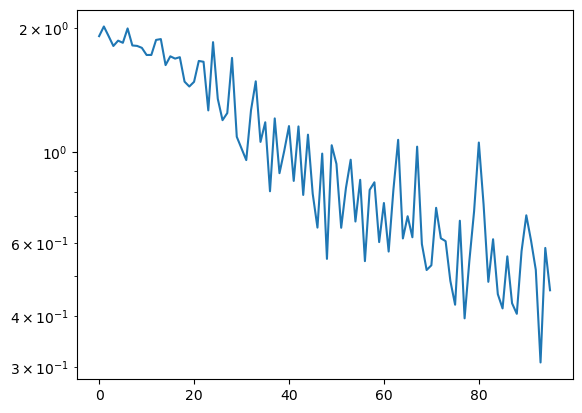

In [133]:
num_episodes = 500
print_every = 50

losses = []

try:
    for episode in range(num_episodes):
        states, actions = run_episode(config, heuristic_agent, device)
        q_values, _ = policy_net(states)
    
        # q_values is of shape: (num_agents, time_step, action_size)
        # actions is of shape: (time_step, num_agents)
    
        q_values = q_values.permute(1, 0, 2)  # (time_step, num_agents, action_size)
        q_values = q_values.reshape(-1, q_values.shape[2])  # (time_step x num_agents, action_size)
        logits = F.log_softmax(q_values, dim=1)
    
        actions = actions.flatten()
    
        optimizer.zero_grad()
        loss = F.cross_entropy(logits.reshape(-1, 7), actions.reshape(-1))
        loss.backward()
        optimizer.step()
    
        losses.append(loss.item())
        if episode % print_every == 0:
            print(f"Episode {episode}, Loss: {losses[-1]}")
except KeyboardInterrupt:
    print("Interrupted")

fig, ax = plt.subplots()
ax.semilogy(losses)

In [114]:
policy_net.save(policy_net_path)

Model saved to ./policy_net


In [117]:
new_policy_net = DRQNNetwork.load(policy_net_path)

In [118]:
new_policy_net.training

False